In [9]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

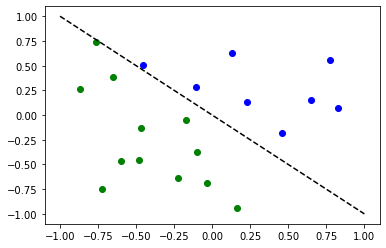

In [10]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}

X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [13]:
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement='linear', reps=1)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters,
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

In [14]:
# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()
def closure():
    optimizer.zero_grad()                  # initialize gradient

    loss = 0.0                                             # initialize loss
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss

    loss.backward()                                        # backward pass

    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

15.65427017211914
14.825811386108398
12.909173965454102
14.387124061584473
13.069238662719727
15.41646671295166
13.95932674407959
14.437867164611816
15.081809043884277
13.949033737182617
13.91576099395752
15.221366882324219
14.175027847290039
13.259071350097656
13.808552742004395
14.849761962890625
15.731021881103516
14.72081184387207
13.3486909866333
15.238088607788086


Accuracy: 0.6


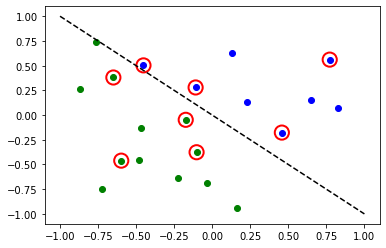

In [15]:
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == y01)/len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [16]:
 model2(Tensor(X[0]))

tensor([0.7569, 0.2431], grad_fn=<_TorchNNFunctionBackward>)